In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## 4.3.1模型
这里我们使用了两个全连接层，隐藏层和输出层

In [2]:
from IPython import display
def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy(net, data_iter): #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval() # 将模型设置为评估模式
    metric = Accumulator(2) # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

class Accumulator: #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

def train_epoch_ch3(net, train_iter, loss, updater): #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):

        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):

        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater): #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [3]:
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

In [4]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)

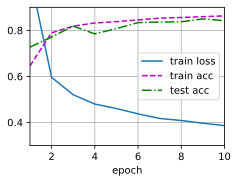

In [5]:
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 4.4 模型选择、欠拟合和过拟合
将模型在训练数据上拟合的比在潜在分布中更接近的现象称之为**过拟合**(overfitting)，用于对抗过拟合的技术成为**正则化**(regularizetion)，表现为在训练集上完美的精度，但是测试机的准确性却下降了
> dropout（随机丢弃和忽略）, L1, L2, 等等正则化技术，防止过拟合
  
> 如果模型数据在一定程度上违反了**独立同分布假设**怎么处理？下面会讨论。

模型复杂性，一般来说，参数更多的，参数取值范围更大的模型更复杂，
> 统计学家认为，能够轻松解释任意事实的模型是复杂的，而表达能力有限但仍能很好地解释数据的模型可能更有现实用途。

训练集，测试集（固定好所有超参数才开始使用），验证集
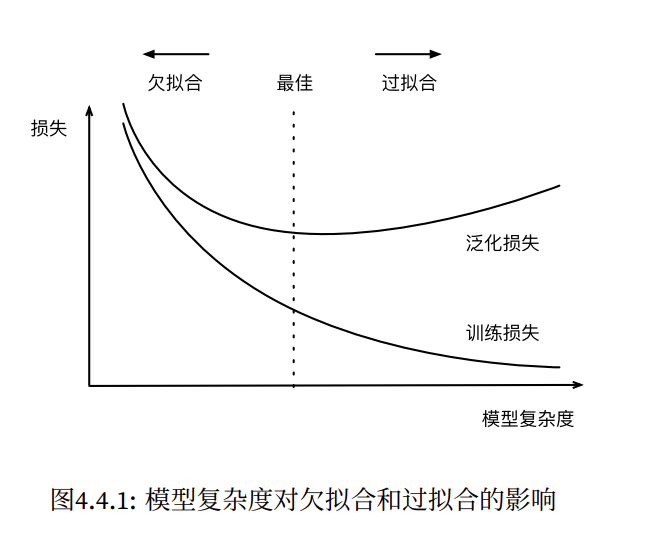

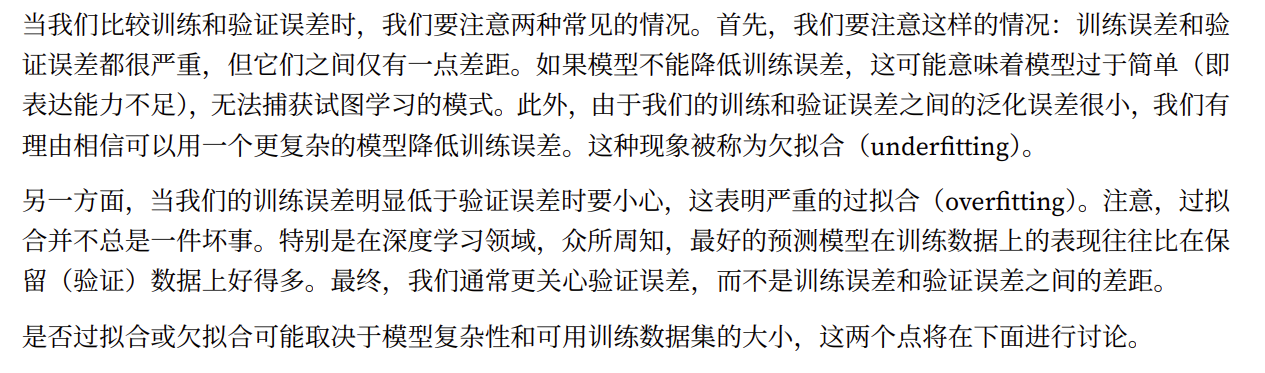


### 4.4.4 多项式回归

In [6]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [28]:
max_degree = 20 # 多项式的最大阶数
n_train, n_test = 100, 100 # 训练和测试数据集大小
true_w = np.zeros(max_degree) # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
# 这里进行了幂次的计算z
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(1) # gamma(n)=(n-1)
    # poly_features[:, i] /= math.gamma(i + 1) # gamma(n)=(n-1)!
    # 这里进行了除以阶乘z
# labels的维度:(n_train+n_test)
labels = np.dot(poly_features, true_w)
# 这里加上了权重z
labels += np.random.normal(scale=0.1, size=labels.shape)

In [29]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
torch.float32) for x in [true_w, features, poly_features, labels]]

In [30]:
features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.9740],
         [-0.1519]]),
 tensor([[ 1.0000e+00, -9.7396e-01,  9.4860e-01, -9.2390e-01,  8.9984e-01,
          -8.7641e-01,  8.5359e-01, -8.3136e-01,  8.0971e-01, -7.8863e-01,
           7.6809e-01, -7.4809e-01,  7.2861e-01, -7.0964e-01,  6.9116e-01,
          -6.7316e-01,  6.5563e-01, -6.3856e-01,  6.2193e-01, -6.0574e-01],
         [ 1.0000e+00, -1.5195e-01,  2.3088e-02, -3.5082e-03,  5.3307e-04,
          -8.1000e-05,  1.2308e-05, -1.8702e-06,  2.8417e-07, -4.3179e-08,
           6.5610e-09, -9.9693e-10,  1.5148e-10, -2.3018e-11,  3.4975e-12,
          -5.3144e-13,  8.0751e-14, -1.2270e-14,  1.8644e-15, -2.8330e-16]]),
 tensor([-4.4202,  4.7473]))

In [31]:
def evaluate_loss(net, data_iter, loss): #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2) # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [32]:
def train(train_features, test_features, train_labels, test_labels,
        num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
    batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
    batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                    xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                    legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                    evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())


weight: [[ 5.002579   1.2072417 -3.402502   5.5982265]]


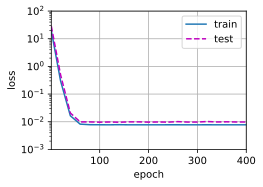

In [33]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
labels[:n_train], labels[n_train:])
# 这里使用三次函数进行拟合，得到很好的结果

weight: [[ 0.8950144 14.854185 ]]


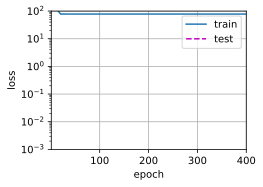

In [34]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
labels[:n_train], labels[n_train:])
# 这里线性，欠拟合

weight: [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan]]


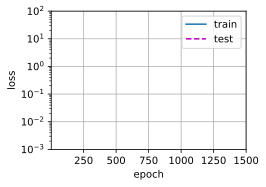

In [35]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
labels[:n_train], labels[n_train:], num_epochs=1500)

## 练习
1. 利用线性代数，可以准确解出
2. 如果不对多项式特征进行**标准化**，可能（下降过快，类似于学习率过大？），而且**nan**的情况出现